In [1]:
import os
newestModel = True #If this is set to true it will use the newest model in the models folder and ignore modelToTest
modelToTest = ''
threads = 16 #Number of threads to use for multithreaded tasks
pathToModelFolder = '/mnt/SPDrive/SPGenerations/Models'
pathToDataFolder = '~/SPDataset/S2DS129-1021DiffReposS245/'
#pathToDataFolder = '~/SPDataset/MiniTestingDataset'
#a folder inthe models folder contains the following files: model.h5, tokenizer.json commitHash.txt (For SCA-Tokenizer)
useCurrentSCATokenizer = '/home/mcall/SPGit/Model-Generation/SCA-Tokenizer' #If this is set to anything other than '' it will use the current SCA-Token in the SCA-Token folder and ignore the modelToTest

In [2]:
import os
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import json
import threading as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
import subprocess
import time
import datetime
import random
import math
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import tokenizer_from_json


def homePath(path):
    if path[0] == '~':
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

pathToModelFolder = homePath(pathToModelFolder)
pathToDataFolder = homePath(pathToDataFolder)

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()


def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                    filesToDo.append(os.path.join(root, file).split(path)[1])
    return filesToDo



2023-11-02 00:19:20.448493: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 00:19:20.482569: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 00:19:20.482591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 00:19:20.482617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 00:19:20.489139: I tensorflow/core/platform/cpu_feature_g

In [3]:
#File Loading


if newestModel:
    models = os.listdir(pathToModelFolder)
    models.sort()
    modelToTest = models[-1]
    print("Using newest model: " + modelToTest)
else:
    print("Using model: " + modelToTest)
model = load_model(pathToModelFolder + '/' +modelToTest + '/model.h5')
print (model.summary())

#load tokenizer from json that used the .tokenizer.save() function
with open(pathToModelFolder + '/' + modelToTest + '/tokenizer.json') as f:
    #have oov token be the first token in the dictionary
    tokenizerModel = tokenizer_from_json(f.read())

Using newest model: 2023-11-01_07-33-44-817361


2023-11-02 00:19:24.578886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13173 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:11:00.0, compute capability: 8.6
2023-11-02 00:19:24.579819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13173 MB memory:  -> device: 1, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6
2023-11-02 00:19:25.695586: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 1024)         819200    
                                                                 
 conv1d (Conv1D)             (None, 498, 2048)         6293504   
                                                                 
 global_max_pooling1d (Glob  (None, 2048)              0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 bidirectional (Bidirection  (None, 1, 2048)           25174016  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 2048)           0

In [4]:
#FOR MORE ADVANCED TESTS.
#pathToSCATokenizerFolder = os.getcwd() + '/SCA-Tokenizer/'
#if (not useCurrentSCATokenizer):
#    #TODO: Configure Git clone on the commit hash



In [4]:
import sys
sys.path.append('./SCA-Tokenizer/')
import TokenizerManager

dfTokens = TokenizerManager.tokenStart(pathToDataFolder, tokenizer=tokenizerModel, multiThreadProcessing = False)

#convert any tokens that are not in the tokenizer to the oov token
#dfTokens['tokens'] = dfTokens['tokens'].apply(lambda x: [y if y in tokenizerModel.word_index else tokenizerModel.oov_token for y in x])

    


completed folder index
Progressing (Not Multithreaded): |██████████████████████████████████████████████████| 100.0% Complete
Finishing
Tokenizing
['var1 1 = { "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strlit" : "strlit" , "strl

In [6]:

#check for any none tokens, and make them the oov token
dfTokens['tokenCode'] = dfTokens['tokenCode'].apply(lambda x: [y if y != None else 1 for y in x])
print (dfTokens)

                                                tokenCode  \
0       [3, 20, 8, 34, 9, 10, 9, 5, 9, 10, 9, 5, 9, 10...   
1       [3, 20, 8, 34, 9, 10, 9, 5, 9, 10, 9, 5, 9, 10...   
2       [3, 20, 8, 439, 6, 15, 6, 9, 5, 15, 9, 14, 7, ...   
3       [3, 20, 8, 439, 6, 15, 6, 9, 5, 15, 9, 14, 7, ...   
4       [9, 3, 20, 8, 34, 9, 10, 9, 5, 9, 10, 9, 5, 9,...   
...                                                   ...   
162451  [27, 126, 27, 88, 388, 43, 1, 4, 4, 27, 1, 43,...   
162452  [27, 126, 27, 168, 27, 82, 27, 1, 43, 1, 4, 4,...   
162453  [27, 126, 27, 168, 27, 82, 27, 1, 43, 1, 4, 4,...   
162454  [27, 126, 27, 168, 27, 82, 27, 1, 43, 1, 4, 4,...   
162455  [27, 241, 27, 712, 43, 1, 4, 4, 27, 43, 1, 4, ...   

                                                     Path  
0       /3719392/version-08.0/xml-config-snippets/xpat...  
1       /3719392/version-08.0/xml-config-snippets/xpat...  
2       /3719392/version-08.0/xml-config-snippets/snip...  
3       /3719392/version-08

In [ ]:
print (dfTokens)

                                                tokenCode  \
0       [3, 20, 8, 34, 9, 10, 9, 5, 9, 10, 9, 5, 9, 10...   
1       [3, 20, 8, 34, 9, 10, 9, 5, 9, 10, 9, 5, 9, 10...   
2       [3, 20, 8, 439, 6, 15, 6, 9, 5, 15, 9, 14, 7, ...   
3       [3, 20, 8, 439, 6, 15, 6, 9, 5, 15, 9, 14, 7, ...   
4       [9, 3, 20, 8, 34, 9, 10, 9, 5, 9, 10, 9, 5, 9,...   
...                                                   ...   
162451  [27, 126, 27, 88, 388, 43, True, 4, 4, 27, Tru...   
162452  [27, 126, 27, 168, 27, 82, 27, True, 43, True,...   
162453  [27, 126, 27, 168, 27, 82, 27, True, 43, True,...   
162454  [27, 126, 27, 168, 27, 82, 27, True, 43, True,...   
162455  [27, 241, 27, 712, 43, True, 4, 4, 27, 43, Tru...   

                                                     Path  
0       /3719392/version-08.0/xml-config-snippets/xpat...  
1       /3719392/version-08.0/xml-config-snippets/xpat...  
2       /3719392/version-08.0/xml-config-snippets/snip...  
3       /3719392/version-08

In [7]:
#Grading Code
sys.path.append('../Auto-Grader/')
import Grader
#prevent warnings from printing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
dfGrades = Grader.bootstrap(pathToDataFolder)

151095sing Files |█████████████████████████████████████████████████-| 99.2% Complete
        fileGrade                                         Path
0       47.400000  /3719392/tools/build_full_templates.py/0.py
1       48.452632  /3719392/tools/build_full_templates.py/1.py
2       52.505263  /3719392/tools/build_full_templates.py/2.py
3       50.557895  /3719392/tools/build_full_templates.py/3.py
4       51.610526  /3719392/tools/build_full_templates.py/4.py
...           ...                                          ...
151090  40.707692          /3719568/test/test_r_reader.py/8.py
151091  39.246154          /3719568/test/test_r_reader.py/9.py
151092  40.784615         /3719568/test/test_r_reader.py/10.py
151093  39.323077         /3719568/test/test_r_reader.py/11.py
151094  40.861538         /3719568/test/test_r_reader.py/12.py

[151095 rows x 2 columns]
Time Taken: 21.31042504310608


In [8]:
combinedDF = pd.merge(dfGrades, dfTokens, on = "Path")


In [9]:
#get max length of tokens from model
maxLen = model.layers[0].input_shape[1]
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]
#reset index
combinedDF = combinedDF.reset_index(drop=True)
#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

In [10]:

#add new colum to combinedDF for the model prediction
combinedDF["predictedGrade"] = None
showMessage = True


"""
    for i, row in combinedDF.iterrows():
        if combinedDF["predictedGrade"][i] == None:
            combinedDF.loc[i, "predictedGrade"] = model.predict(np.array(row["tokenCode"]).reshape(1, -1))
            if showMessage:
                printProgressBar(i, len(combinedDF), prefix = 'Progress:', suffix = 'Complete', length = 50)
            print(np.array(np.array(row["tokenCode"]).reshape(1, -1)))
            break
"""
    #INSTEAD OF ITTERATING FEED THE WHOLE LIST
combinedDF["predictedGrade"] = model.predict(np.array(combinedDF["tokenCode"].tolist()))


#make dir if it doesn't exist
if not os.path.exists(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest):
    os.makedirs(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest)



combinedDF.to_pickle(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest + '/combinedDF.pkl')
dataSetVersion = pathToDataFolder

#write that to a file
with open(homePath("~/SPGenerations/") + '/' + "testingData" + '/' + modelToTest + '/dataSetVersion.txt', 'w') as file:
    file.write(dataSetVersion)
    
        



2023-11-02 01:23:55.493243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-02 01:23:56.113826: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1185/1185 [==============================] - 52s 40ms/step


In [4]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
def homePath(path):
    return os.path.join(os.path.expanduser("~"), path.strip("~/"))


def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()



#loading previous testingData
testingDataVersion = "2023-10-17 18:59:54.067245"
testingDataVersion = "2023-10-28 15:06:35.098494"

testingDataPath = homePath("~/SPGenerations/") + '/' + "testingData" + '/' + testingDataVersion
combinedDF = pd.read_pickle(testingDataPath + '/combinedDF.pkl')


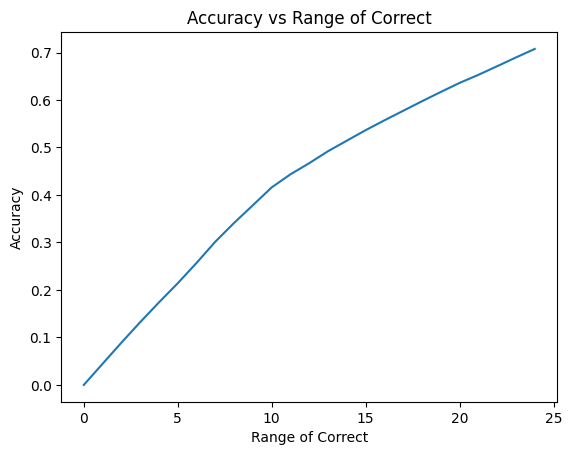

In [11]:
#check accuracy
correct = 0
total = 0


def getGradeRange(rangeofCorrect):
    correct = 0
    total = 0
    for i in combinedDF.index:
        if (combinedDF.at[i, "predictedGrade"] <= combinedDF.at[i, "fileGrade"] + rangeofCorrect and combinedDF.at[i, "predictedGrade"] >= combinedDF.at[i, "fileGrade"] - rangeofCorrect):
            correct += 1
        total += 1
    return correct, total



#generate a graph
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 25, 1)
y = []
for i in x:
    correct, total = getGradeRange(i)
    y.append(correct/total)
plt.plot(x, y)
plt.xlabel('Range of Correct')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Range of Correct')
plt.show()




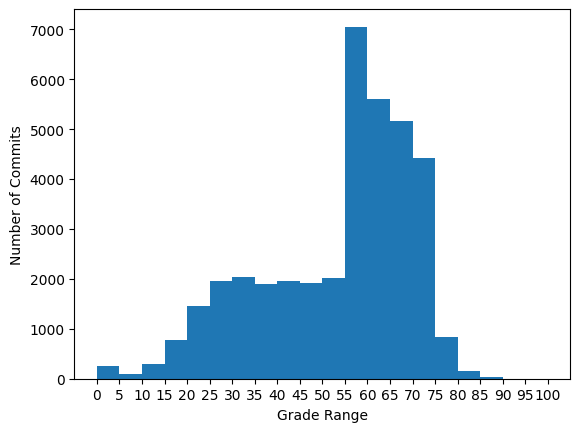

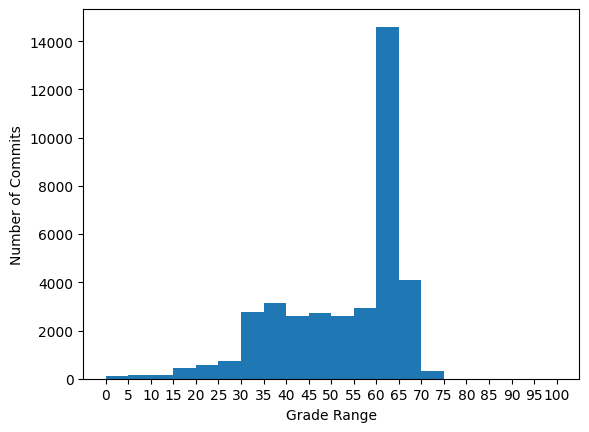

In [12]:
#generate graph showing range of grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()

graph = plt.hist(combinedDF['predictedGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()

In [13]:
incriments = 20


#break up the data into incriments
for i in range(incriments):
    #get the data for the incriments
    incrimentsDF = combinedDF[(combinedDF["fileGrade"] >= i * 100 / incriments) & (combinedDF["fileGrade"] < (i + 1) * 100 / incriments)]
    #get the accuracy for the incriments
    correct = 0
    total = 0
    for j in incrimentsDF.index:
        if (incrimentsDF.at[j, "predictedGrade"] <= incrimentsDF.at[j, "fileGrade"] + rangeofCorrect and incrimentsDF.at[j, "predictedGrade"] >= incrimentsDF.at[j, "fileGrade"] - rangeofCorrect):
            correct += 1
        total += 1
    #print the accuracy
    if(total != 0):
        print ("Accuracy for incriments " + str(i * 100 / incriments) + "% - " + str((i + 1) * 100 / incriments) + "%: " + str(correct/total * 100) + "%")


NameError: name 'rangeofCorrect' is not defined

In [14]:
#comparitive commits tests

#Make an array of dataframes which are created from combinedDF, and are split by their original file

#Get the list of files
files = combinedDF["Path"]


#split all the files by the last / and get the first element of the split

files = [file.rsplit("/",1)[0] for file in files]
#remove duplicates
files = list(dict.fromkeys(files))

#reset index

#make an array of dataframes
dataframes = []
for i in range(len(files)):
    dataframes.append([])
for i in combinedDF.index:
    #get index of files where the file name is the same as the current file name
    index = files.index(combinedDF.at[i, "Path"].rsplit("/",1)[0])
    dataframes[index].append(combinedDF.iloc[i])

In [15]:
#per file commit simple test, checks if the previous commit is less than or equal to the current commit
correct = 0
equal = 0
total = 0
for dataframe in dataframes:
    for i in range(1, len(dataframe)):
        #make sure that the length of the dataframe is greater than 1
        if (dataframe[i]["predictedGrade"] > dataframe[i - 1]["predictedGrade"]):
            correct += 1
            total += 1
        elif (dataframe[i]["predictedGrade"] == dataframe[i - 1]["predictedGrade"]):
            equal += 1
        else:
            total += 1
print ("Accuracy for per commit simple test: " + str(correct/total * 100) + "%")

Accuracy for per commit simple test: 52.14077294110642%


Average correct score: 4.456599153653162
Average incorrect score: -3.9704196599158124
Accuracy for per file commit gap test of size 1 : 52.14077294110642%
Average correct score: 5.246583948363318
Average incorrect score: -4.557346348587609
Accuracy for per file commit gap test of size 2 : 52.07397346149828%
Average correct score: 6.140360356027464
Average incorrect score: -5.225238015782797
Accuracy for per file commit gap test of size 3 : 52.26133421473035%
Average correct score: 6.664216885098103
Average incorrect score: -5.674058259660798
Accuracy for per file commit gap test of size 4 : 52.45952292670869%
Average correct score: 7.044858568670401
Average incorrect score: -5.99970085574512
Accuracy for per file commit gap test of size 5 : 52.26340410219503%
Average correct score: 7.374002924922086
Average incorrect score: -6.322136295364264
Accuracy for per file commit gap test of size 6 : 52.21231493943472%
Average correct score: 7.55253926643623
Average incorrect score: -6.36252167

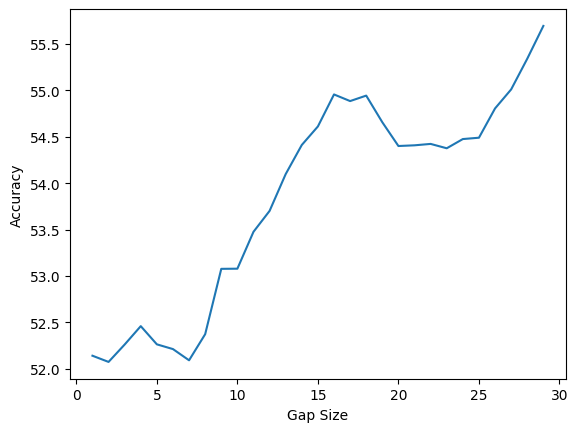

In [16]:
#per file commit gap test, checks if the previous commit is less than or equal to the current commit in a gap of 10

def gapTest(gap):
    correct = 0
    equal = 0
    total = 0
    avgCorrectScore = 0
    avgIncorrectScore = 0
    for dataframe in dataframes:
        for i in range(gap, len(dataframe)):
            #make sure that the length of the dataframe is greater than 1
            if (dataframe[i]["predictedGrade"] > dataframe[i - gap]["predictedGrade"]):
                correct += 1
                avgCorrectScore += dataframe[i]["predictedGrade"] - dataframe[i - gap]["predictedGrade"]
                total += 1
            elif (dataframe[i]["predictedGrade"] == dataframe[i - gap]["predictedGrade"]):
                equal += 1
            else:
                avgIncorrectScore += dataframe[i]["predictedGrade"] - dataframe[i - gap]["predictedGrade"]
                total += 1
    if (total != 0):
        avgCorrectScore /= correct
        avgIncorrectScore /= total - correct
        print ("Average correct score: " + str(avgCorrectScore))
        print ("Average incorrect score: " + str(avgIncorrectScore))

    print ("Accuracy for per file commit gap test of size " + str(gap) + " : " + str(correct/total * 100) + "%")

    return correct/total * 100 


for i in range(1, 30):
    gapTest(i)

#graph this
x = []
y = []
for i in range(1, 30):
    x.append(i)
    y.append(gapTest(i))
plt.plot(x, y)
plt.xlabel("Gap Size")
plt.ylabel("Accuracy")
plt.show()
